# Week 6

## Importing Libraries

In [8]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

## Data Preprocessing

We will continue to use the IMDB dataset for this week's examples.

In [5]:
imdb_df = pd.read_csv(r"C:\Users\liuru\Desktop\EE6405\Data\IMDB\IMDB Dataset.csv")
df_positive = imdb_df[imdb_df['sentiment']=='positive'][:5000]
df_negative = imdb_df[imdb_df['sentiment']=='negative'][:5000]
imdb = pd.concat([df_positive,df_negative ])
imdb.shape

(10000, 2)

In [6]:
# remove "(<.*?>)" markup
imdb['review'] = imdb['review'].apply(lambda x: re.sub('(<.*?>)', ' ', x))
# remove punctuation marks 
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
# remove whitespace
imdb['review'] = imdb['review'].apply(lambda x: x.strip())
# remove all strings that contain a non-letter
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
# convert to lower
imdb['review'] = imdb['review'].apply(lambda x: x.lower())

In [9]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [11]:
imdb['review']=imdb['review'].apply(tagged_lemma)

In [12]:
imdb.sentiment = imdb.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [17]:
from sklearn.model_selection import train_test_split
training_set, test_set= train_test_split(imdb, test_size=0.25, random_state=42)

In [18]:
training_set

,review,sentiment
9758,brother with psychokinetic power yes really du...,1
8709,goodnight mister tom be so beautifully film an...,1
3411,ok just what the hell be all this suppose to m...,0
9644,i don t honestly know what legal or illegal su...,0
2171,when i rent this movie i think i be go to see ...,1
...,...,...
1501,yes bad act isn t only one thing to mention ba...,0
358,this movie feature charlie spradling dancing i...,0
761,i think my summary say it all this mtv ish ans...,0
1685,it s unbelievable but the fourth be well than ...,1


## RNNs

Importing libraries:
We will use the tensorflow library to conctruct out neural models.

In [1]:
import numpy as np
import tensorflow as tf

### Text Encoder:
The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. 

In [31]:
reviews = training_set['review'].tolist()

In [34]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    pad_to_max_tokens=True
)
encoder.adapt(reviews)

vocab = np.array(encoder.get_vocabulary())

In [35]:
vocab[:20]

array(['', '[UNK]', 'the', 'be', 'and', 'a', 'of', 'to', 'it', 'in', 'i',
       'this', 'that', 's', 'have', 'movie', 'film', 'as', 'with', 'for'],
      dtype='<U14')

In [36]:
training_set.review.iloc[0]

'brother with psychokinetic power yes really duel not just for debra winger s affection but really over a secret from their childhood that leave them at odds over their power there be surreal touches the fire brigade that act like a singing greek chorus but there be also humour wit and romance the soundtrack be great also and similar to the way american werewolf in london use every great wolf song they could get but with fire and i don t think i ll ever forget dennis quaid mmmmm dennis quaid set his own trailer a rockin too she s a lady priceless best line miss from the quote section btw once you ve have a clown you never go back i love this movie i just order the dvd from the us and if the comment write by the kind of people who d be happier with legally blond don t put you off give it a try'

In [46]:
encoded_example = encoder(training_set.review.iloc[3]).numpy()
encoded_example

array([ 10,  98,  23,   1,  82,  49,   1,  45,   1,   1,  31,   2, 414,
         3,  22,  53,   2, 200,  11,   1, 319,   6,   1,   2, 178, 698,
         2, 113, 698,   2, 682, 698,   2, 227, 848,   6,   2,  15,   3,
        12,   5, 176,  18,   1,   1, 490,  94, 587,   5,   1, 733,   1,
        21,  42,  14,   7,   3, 457,  47,   6, 126, 306,   7,  59,  66,
       183,   6,  11,   2,  72, 244,  10,  14,   7,  59,   8,   8,   3,
        22,   2, 130,   1,  17, 142,   6,   5, 118, 370,   1,   4,   2,
        15,  12,  94,  22, 109,   8,   3,   2, 138,  27,  12,  10, 123,
         7,  39,  10, 705, 842, 147,   2, 227, 102,   4,   3,  42, 922,
        90, 355,  11,  15,   3,   9,   1,   1,  28,  24, 488, 446,  45,
        59,  11,   1,   1,   9,   2,  15,  98,  23, 698,  17,  81,  17,
         2, 463,  15,   4, 353,  28,  48,  21, 123,   5,  40,   1, 733,
        15,   2,   1,  18, 571,   1,   1,   1,   1,   1, 312,  15,   7,
        59, 210, 488,   9, 240,   6,  11, 319,   6, 911,   1,  2

### Unidirectional RNN:
To create a unidirectional RNN, we build the model as a tf.keras.Sequential.

The first layer is the encoder, which converts the text to a sequence of token indices.

After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [52]:
simpleRNN = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

We use the Binary Crossentropy Loss since we are dealing with Binary Classification. We also use the Adam optmizer. We use a smaller learning rate.

In [53]:
simpleRNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [55]:
historyRNN = simpleRNN.fit(training_set['review'],training_set['sentiment'], epochs=10,
                    validation_data=(test_set['review'],test_set['sentiment']), 
                    validation_steps=30)

Epoch 1/10
235/235 [==============================] - 20s 80ms/step - loss: 0.6908 - accuracy: 0.5029 - val_loss: 0.6813 - val_accuracy: 0.4912
Epoch 2/10
235/235 [==============================] - 19s 79ms/step - loss: 0.6801 - accuracy: 0.5036 - val_loss: 0.6852 - val_accuracy: 0.4912
Epoch 3/10
235/235 [==============================] - 19s 79ms/step - loss: 0.6780 - accuracy: 0.5099 - val_loss: 0.6924 - val_accuracy: 0.4912
Epoch 4/10
235/235 [==============================] - 19s 80ms/step - loss: 0.6620 - accuracy: 0.5293 - val_loss: 0.5924 - val_accuracy: 0.6464
Epoch 5/10
235/235 [==============================] - 19s 81ms/step - loss: 0.5773 - accuracy: 0.6739 - val_loss: 0.5338 - val_accuracy: 0.7408
Epoch 6/10
235/235 [==============================] - 19s 82ms/step - loss: 0.5939 - accuracy: 0.6931 - val_loss: 0.4760 - val_accuracy: 0.7832
Epoch 7/10
235/235 [==============================] - 19s 80ms/step - loss: 0.4489 - accuracy: 0.7976 - val_loss: 0.4279 - val_accuracy:

### LSTM:
To modify the code and create an LSTM model, we simply change the RNN layer to an LSTM layer.

In [56]:
lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64), #Replacing the simple RNN with a LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [58]:
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [59]:
historyLSTM = lstm.fit(training_set['review'],training_set['sentiment'], epochs=10,
                    validation_data=(test_set['review'],test_set['sentiment']), 
                    validation_steps=30)

Epoch 1/10
235/235 [==============================] - 45s 180ms/step - loss: 0.6915 - accuracy: 0.5029 - val_loss: 0.6823 - val_accuracy: 0.4912
Epoch 2/10
235/235 [==============================] - 43s 184ms/step - loss: 0.6022 - accuracy: 0.6168 - val_loss: 0.6392 - val_accuracy: 0.4912
Epoch 3/10
235/235 [==============================] - 45s 190ms/step - loss: 0.5002 - accuracy: 0.7167 - val_loss: 0.4852 - val_accuracy: 0.8268
Epoch 4/10
235/235 [==============================] - 44s 188ms/step - loss: 0.3882 - accuracy: 0.8361 - val_loss: 0.3698 - val_accuracy: 0.8400
Epoch 5/10
235/235 [==============================] - 45s 190ms/step - loss: 0.3316 - accuracy: 0.8635 - val_loss: 0.3397 - val_accuracy: 0.8516
Epoch 6/10
235/235 [==============================] - 44s 189ms/step - loss: 0.3095 - accuracy: 0.8735 - val_loss: 0.3708 - val_accuracy: 0.8472
Epoch 7/10
235/235 [==============================] - 45s 191ms/step - loss: 0.2939 - accuracy: 0.8824 - val_loss: 0.3368 - val_ac

### Bi-Directional LSTM:
To implement the Bi-directional LSTM, we modify the code as follows:

In [60]:
biDir = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #Replacing the LSTM with a bidirectional LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [61]:
biDir.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [62]:
historybiDir = biDir.fit(training_set['review'],training_set['sentiment'], epochs=10,
                    validation_data=(test_set['review'],test_set['sentiment']), 
                    validation_steps=30)

Epoch 1/10
235/235 [==============================] - 89s 357ms/step - loss: 0.6924 - accuracy: 0.5029 - val_loss: 0.6901 - val_accuracy: 0.4912
Epoch 2/10
235/235 [==============================] - 98s 418ms/step - loss: 0.6247 - accuracy: 0.5997 - val_loss: 0.5227 - val_accuracy: 0.7112
Epoch 3/10
235/235 [==============================] - 103s 439ms/step - loss: 0.4905 - accuracy: 0.7407 - val_loss: 0.4683 - val_accuracy: 0.7336
Epoch 4/10
235/235 [==============================] - 104s 443ms/step - loss: 0.4500 - accuracy: 0.7604 - val_loss: 0.4357 - val_accuracy: 0.8104
Epoch 5/10
235/235 [==============================] - 109s 466ms/step - loss: 0.4027 - accuracy: 0.8176 - val_loss: 0.4594 - val_accuracy: 0.7744
Epoch 6/10
235/235 [==============================] - 109s 466ms/step - loss: 0.4058 - accuracy: 0.8080 - val_loss: 0.3897 - val_accuracy: 0.8204
Epoch 7/10
235/235 [==============================] - 106s 451ms/step - loss: 0.3412 - accuracy: 0.8513 - val_loss: 0.3696 - v

### GRUs:
Similarly, to create a GRU, we simply replace the corresponding layer.

In [69]:
gru = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.GRU(64),  # Replace with a GRU layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [70]:
gru.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [71]:
historyGRU = gru.fit(training_set['review'],training_set['sentiment'], epochs=10,
                    validation_data=(test_set['review'],test_set['sentiment']), 
                    validation_steps=30)

Epoch 1/10
235/235 [==============================] - 57s 233ms/step - loss: 0.6921 - accuracy: 0.5029 - val_loss: 0.6910 - val_accuracy: 0.4912
Epoch 2/10
235/235 [==============================] - 46s 197ms/step - loss: 0.6820 - accuracy: 0.5031 - val_loss: 0.6655 - val_accuracy: 0.4976
Epoch 3/10
235/235 [==============================] - 47s 202ms/step - loss: 0.4847 - accuracy: 0.7397 - val_loss: 0.3870 - val_accuracy: 0.8360
Epoch 4/10
235/235 [==============================] - 51s 217ms/step - loss: 0.3494 - accuracy: 0.8512 - val_loss: 0.3712 - val_accuracy: 0.8296
Epoch 5/10
235/235 [==============================] - 44s 188ms/step - loss: 0.3098 - accuracy: 0.8743 - val_loss: 0.3457 - val_accuracy: 0.8444
Epoch 6/10
235/235 [==============================] - 44s 188ms/step - loss: 0.2912 - accuracy: 0.8809 - val_loss: 0.3519 - val_accuracy: 0.8332
Epoch 7/10
235/235 [==============================] - 47s 200ms/step - loss: 0.2825 - accuracy: 0.8847 - val_loss: 0.3341 - val_ac

The matplotlib library will be used to track our model's metrics

In [63]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

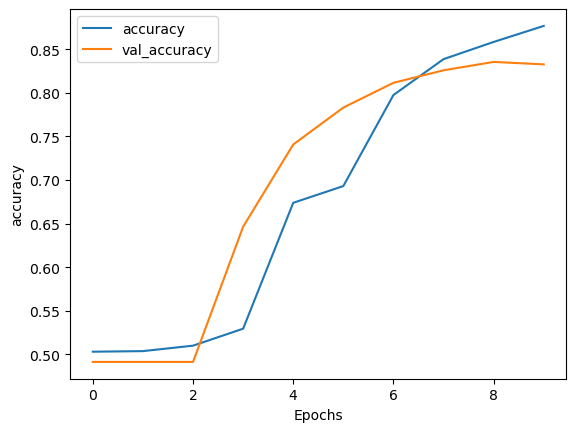

In [64]:
plot_graphs(historyRNN, "accuracy")

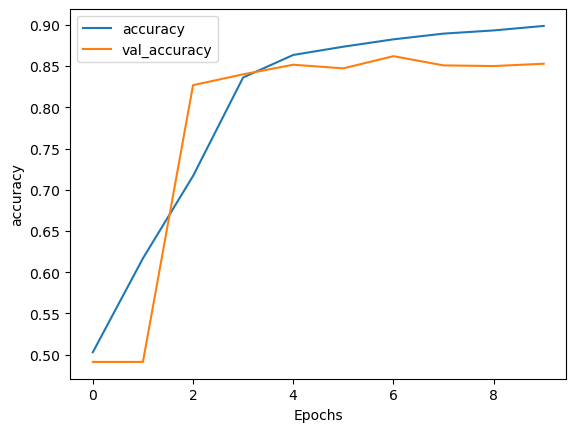

In [65]:
plot_graphs(historyLSTM, "accuracy")

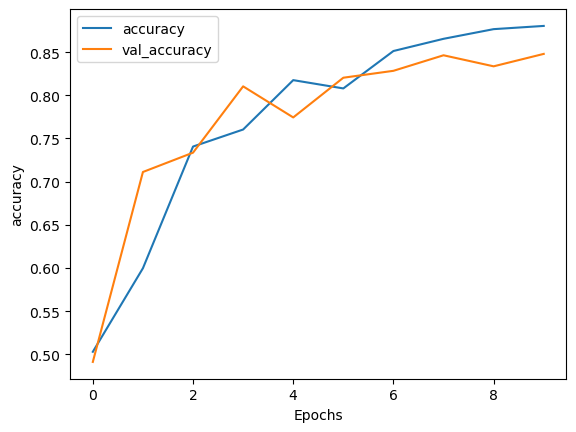

In [67]:
plot_graphs(historybiDir, "accuracy")

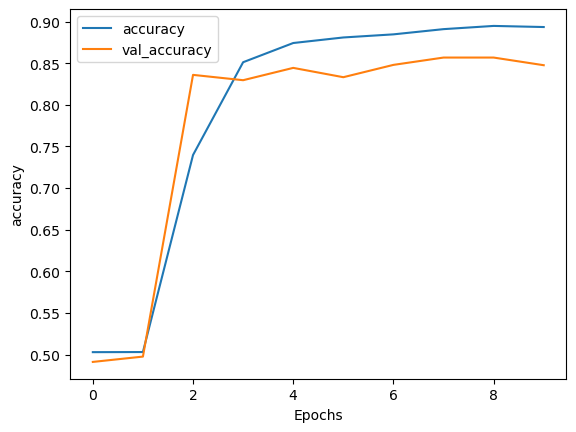

In [72]:
plot_graphs(historyGRU, "accuracy")